# Exploración de generación de imágenes basado en PDF's

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PyPDF2 import PdfReader
from pathlib import Path
from pdf2image import convert_from_path
import random


import sys
root = Path().resolve().parent
sys.path.append(str(root))

from src.budget_buddy.utils.io import ensureDirs

In [2]:
ROOT = Path("..").resolve()
TRAIN_SPLIT_ROOT = ROOT / "data" / "splits" / "train"
PREVIEW_DIR = ROOT / "data" / "interim" / "pdf_previews"

ensureDirs([PREVIEW_DIR])
print("train split:", TRAIN_SPLIT_ROOT)
print("preview dir:", PREVIEW_DIR)


train split: D:\repositorios\UVG\2025\BudgetBuddy\data\splits\train
preview dir: D:\repositorios\UVG\2025\BudgetBuddy\data\interim\pdf_previews


## Tomar una muestra de PDFs

In [3]:
def samplePdfsPerCategory(max_per_category: int = 2, max_categories: int = 5):
    if not TRAIN_SPLIT_ROOT.exists():
        raise FileNotFoundError(f"no existe {TRAIN_SPLIT_ROOT}, corre build-train primero")

    samples = []

    cat_dirs = [d for d in sorted(TRAIN_SPLIT_ROOT.iterdir()) if d.is_dir()]
    random.seed(42)
    random.shuffle(cat_dirs)
    cat_dirs = cat_dirs[:max_categories]

    for cat_dir in cat_dirs:
        category = cat_dir.name
        pdf_paths = sorted(cat_dir.glob("*.pdf"))
        if not pdf_paths:
            continue

        random.shuffle(pdf_paths)
        pdf_paths = pdf_paths[:max_per_category]

        for pdf_path in pdf_paths:
            samples.append({
                "category": category,
                "pdf_path": pdf_path
            })

    return samples


samples = samplePdfsPerCategory(max_per_category=2, max_categories=5)
len(samples), samples[:3]

(10,
 [{'category': 'servicios_internet_telefonia',
   'pdf_path': WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/splits/train/servicios_internet_telefonia/FDEB1496-AFC3-4AAF-8839-7241FAAB9590.pdf')},
  {'category': 'servicios_internet_telefonia',
   'pdf_path': WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/splits/train/servicios_internet_telefonia/2E7D858B-DF2E-401C-829F-2E4A7CAF9DCE.pdf')},
  {'category': 'finanzas',
   'pdf_path': WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/splits/train/finanzas/C25A67CE-F2CA-46FA-B7A5-75B12EACA285.pdf')}])

## Función para convertir un PDF a imágenes

In [4]:
def pdfToImages(pdf_path: Path, dpi: int = 300):
    poppler_path = r"C:\poppler-25.11.0\Library\bin"
    images = convert_from_path(str(pdf_path), dpi=dpi, poppler_path=poppler_path)
    return images

## Visualizar PDFs convertidos

pdf: D:\repositorios\UVG\2025\BudgetBuddy\data\splits\train\servicios_internet_telefonia\FDEB1496-AFC3-4AAF-8839-7241FAAB9590.pdf
dpi: 300
paginas generadas: 1
  pagina 1: 2550x3300 px


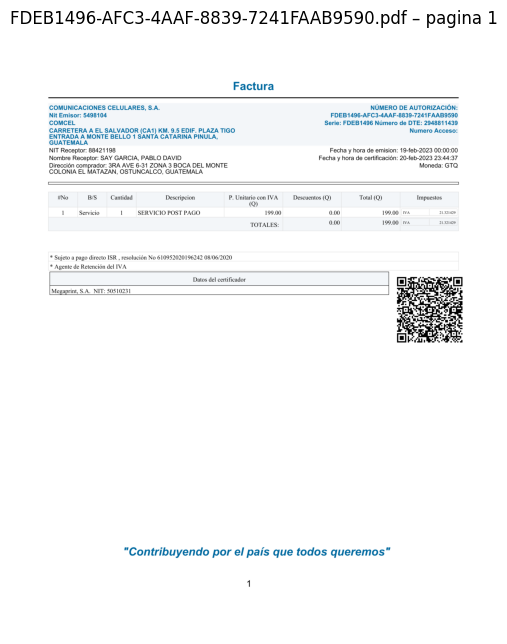

pdf: D:\repositorios\UVG\2025\BudgetBuddy\data\splits\train\servicios_internet_telefonia\2E7D858B-DF2E-401C-829F-2E4A7CAF9DCE.pdf
dpi: 300
paginas generadas: 1
  pagina 1: 2550x3300 px


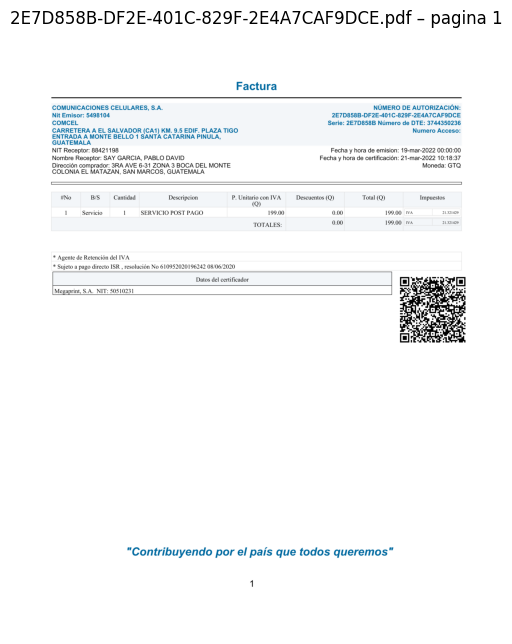

pdf: D:\repositorios\UVG\2025\BudgetBuddy\data\splits\train\finanzas\C25A67CE-F2CA-46FA-B7A5-75B12EACA285.pdf
dpi: 300
paginas generadas: 1
  pagina 1: 2550x3300 px


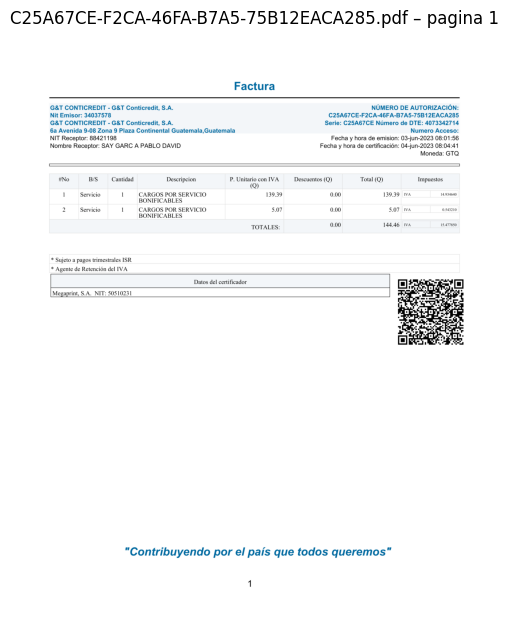

In [5]:
def showPdfAsImages(pdf_path: Path, dpi: int = 300, max_pages: int | None = 2):
    print("=" * 80)
    print(f"pdf: {pdf_path}")
    print(f"dpi: {dpi}")

    images = pdfToImages(pdf_path, dpi=dpi)
    print(f"paginas generadas: {len(images)}")

    if max_pages is not None:
        images = images[:max_pages]

    for idx, img in enumerate(images):
        w, h = img.size
        print(f"  pagina {idx + 1}: {w}x{h} px")

        plt.figure(figsize=(6, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{pdf_path.name} – pagina {idx + 1}")
        plt.show()


# probar con los primeros 3 de la muestra
for row in samples[:3]:
    showPdfAsImages(row["pdf_path"], dpi=300, max_pages=1)

## Guardar imágenes a disco para inspección externa

In [6]:
def savePdfPreviewImages(samples, dpi: int = 300, max_pages: int | None = 1):
    saved = []

    for row in samples:
        category = row["category"]
        pdf_path = row["pdf_path"]

        images = pdfToImages(pdf_path, dpi=dpi)
        if max_pages is not None:
            images = images[:max_pages]

        for idx, img in enumerate(images):
            out_dir = PREVIEW_DIR / category
            out_dir.mkdir(parents=True, exist_ok=True)

            out_name = f"{pdf_path.stem}_page{idx + 1}_dpi{dpi}.png"
            out_path = out_dir / out_name

            img.save(out_path)
            saved.append(out_path)

    print(f"imagenes guardadas: {len(saved)}")
    return saved


saved_paths = savePdfPreviewImages(samples, dpi=300, max_pages=1)
saved_paths[:5]


imagenes guardadas: 10


[WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/interim/pdf_previews/servicios_internet_telefonia/FDEB1496-AFC3-4AAF-8839-7241FAAB9590_page1_dpi300.png'),
 WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/interim/pdf_previews/servicios_internet_telefonia/2E7D858B-DF2E-401C-829F-2E4A7CAF9DCE_page1_dpi300.png'),
 WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/interim/pdf_previews/finanzas/C25A67CE-F2CA-46FA-B7A5-75B12EACA285_page1_dpi300.png'),
 WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/interim/pdf_previews/finanzas/520E733B-C2C8-4B3F-BD5C-7C042F730901_page1_dpi300.png'),
 WindowsPath('D:/repositorios/UVG/2025/BudgetBuddy/data/interim/pdf_previews/compras_personales/7878C64D-A0CA-43B1-96D7-10C20E8776A0_page1_dpi300.png')]